In [1]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
#import plotly.figure_factory as ff
import xmitgcm as xm
import xgcm
import pickle
import eddytools as et
#from cmocean import cm
from scipy.signal import convolve

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
# Obviously it is not a great idea to ignore warnings, however there are quite many
# RuntimeWarnings because of division by 0 in some parts of this notebook. To keep
# the instructive nature of this example notebook, these warnings are ignored.

Uncomment the following cell to use `dask distributed` (i.e for use with `dask_bags` in the detection).  
__This is experimental not thouroughly tested__

In [2]:
#from dask.distributed import Client, LocalCluster
#cluster = LocalCluster(n_workers=1, threads_per_worker=4)
#client = Client(cluster)
#client

In [3]:
# paths
datapath = '/storage/alplakes_test/MITgcm_results_Leman_Sep2021/results/'
gridpath = datapath
outputpath = '/home/leroquan@eawag.wroot.emp-eaw.ch/eddytools/workspace/'
output_name = 'data_OW_std_20210902.nc'
ref_date = "2021-07-26 0:0:0"

In [4]:
str_start_time = "2021-09-09T00:30:00.000000000"
str_end_time = "2021-09-10T00:30:00.000000000"

start_date_analysis = np.datetime64(str_start_time)
end_date_analysis = np.datetime64(str_end_time)

### Loading data
In case the MITgcm output is in binary format (`*.meta` and `*.data`), use `xmitgcm` to load the data. If the data is in `netCDF` format, make sure that you define all the necessary grid information for `xgcm` to work properly!

In [5]:
# load data
dt = 4.
data = xm.open_mdsdataset(datapath, delta_t=dt,
                            ignore_unknown_vars=True, grid_dir=gridpath, 
                            geometry="cartesian", calendar="standard", ref_date=ref_date, 
                            prefix="3Dsnaps", endian='<')
data = data.sel(time=slice(start_date_analysis, end_date_analysis))
#data = data.chunk({'time': 1, 'Z': 55, 'Zl': 55, 'Zu': 55, 'Zp1': 56, 'XC': 250, 'XG': 250, 'YC': 300, 'YG': 300})

In [9]:
data

<xarray.Dataset>
Dimensions:  (XC: 1344, YC: 528, XG: 1344, YG: 528, Z: 100, Zp1: 101, Zu: 100,
              Zl: 100, time: 25)
Coordinates: (12/34)
  * XC       (XC) float32 25.0 75.0 125.0 ... 6.708e+04 6.712e+04 6.718e+04
  * YC       (YC) float32 25.0 75.0 125.0 ... 2.628e+04 2.632e+04 2.638e+04
  * XG       (XG) float32 0.0 50.0 100.0 150.0 ... 6.705e+04 6.71e+04 6.715e+04
  * YG       (YG) float32 0.0 50.0 100.0 150.0 ... 2.625e+04 2.63e+04 2.635e+04
  * Z        (Z) float32 -0.25 -0.7575 -1.281 -1.82 ... -295.6 -305.2 -315.1
  * Zp1      (Zp1) float32 0.0 -0.5 -1.015 -1.546 ... -300.4 -310.1 -320.1
    ...       ...
    rhoRef   (Z) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    dyF      (YC, XC) float32 dask.array<chunksize=(528, 1344), meta=np.ndarray>
    dxF      (YC, XC) float32 dask.array<chunksize=(528, 1344), meta=np.ndarray>
    dxV      (YG, XG) float32 dask.array<chunksize=(528, 1344), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2021-09-09T00:30:00 ... 2021-09-10T00:30:00
Data variables:
    UVEL     (time, Z, YC, XG) float32 dask.array<chunksize=(1, 100, 528, 1344), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) float32 dask.array<chunksize=(1, 100, 528, 1344), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 100, 528, 1344), meta=np.ndarray>
    THETA    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 100, 528, 1344), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/storage/alpl...

In [10]:
# define metrics for xgcm (not strictly necessary)
data['drW'] = data.hFacW * data.drF #vertical cell size at u point
data['drS'] = data.hFacS * data.drF #vertical cell size at v point
data['drC'] = data.hFacC * data.drF #vertical cell size at tracer point
data = data.set_coords(["drW", "drS", "drC"])

metrics = {
    ('X'): ['dxC', 'dxG', 'dxF', 'dxV'], # X distances
    ('Y'): ['dyC', 'dyG', 'dyF', 'dyU'], # Y distances
    ('Z'): ['drF', 'drW', 'drS', 'drC'], # Z distances
    ('X', 'Y'): ['rAw', 'rAs', 'rA', 'rAz'] # Areas in x-y plane
}

In [58]:
temp_ini = data.THETA.isel(time=0,Z=0)
mask = temp_ini.where(abs(temp_ini) > 1e-10).values

### OKUBO-WEISS
We use xgcm to define the grid for the interpolation and differentiation necessary for the calculation of vorticity and the Okubo-Weiss parameter.  
For more information on the Okubo-Weiss parameter and its calculation see [Okubo, 1970](https://doi.org/10.1016/0011-7471(70)90059-8); [Weiss, 1991](https://doi.org/10.1016/0167-2789(91)90088-Q); [Basdevant and Philipovitch, 1994](https://doi.org/10.1016/0167-2789(94)90222-4); [Chelton et al., 2007](https://doi.org/10.1029/2007GL030812).  
The Okubo-Weiss parameter is only calculated on one depth level because we will only do the detection on one level.

In [11]:
grid = xgcm.Grid(data, metrics=metrics)

In [12]:
# Calculate vorticity and Okubo-Weiss parameter
data_OW = et.okuboweiss.calc(data.isel(Z=0, Zu=0, Zl=0, Zp1=0), grid, 'UVEL', 'VVEL')

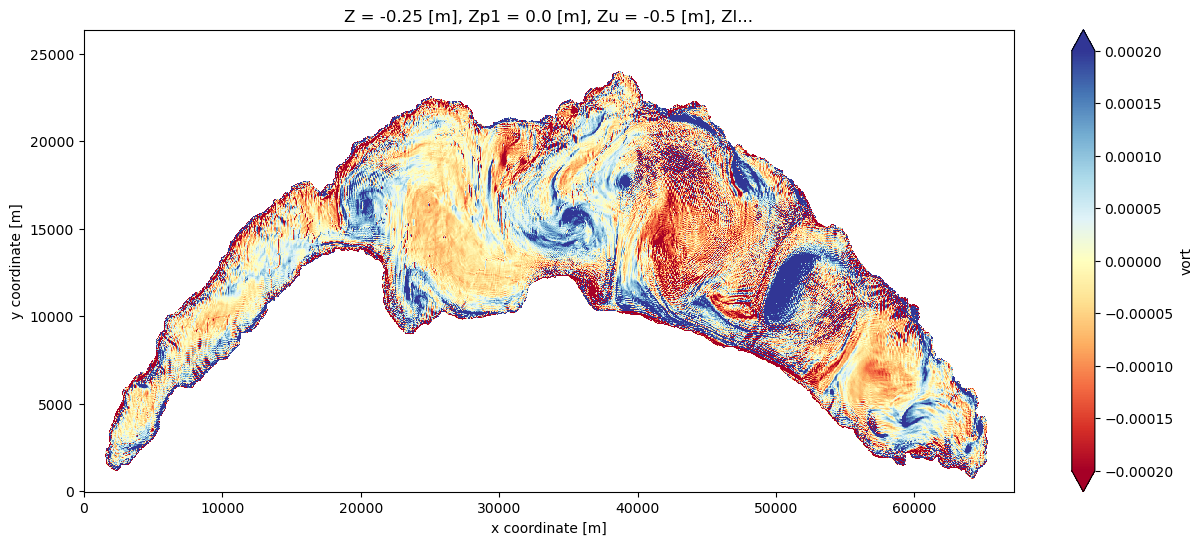

In [83]:
data_OW.vort.sel(time=data_OW['time'][0]).where(~np.isnan(mask)).plot(figsize=(15,6), vmin= -2e-4, vmax=2e-4, cmap='RdYlBu')

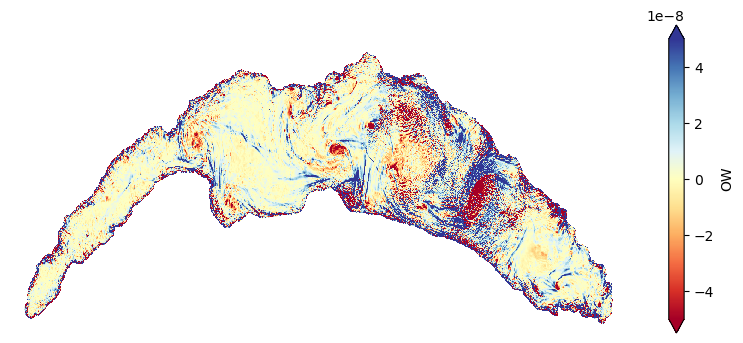

In [106]:
fig, ax = plt.subplots(figsize=(10,4))

data_OW['OW'].sel(time=data_OW['time'][0]).where(~np.isnan(mask)).plot(ax=ax, vmin= -5e-8, vmax=5e-8, cmap='RdYlBu')

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
#plt.savefig('OW_geneva.png')

In [53]:
# Merge the new variables `OW` and `vort` to the dataset `data` and make sure the chunk sizes are as before.
data = xr.merge([data, data_OW], compat='override').chunk({'XC': 250, 'XG': 250, 'YC': 300, 'YG': 300})

In [122]:
import matplotlib.colors as mcolors
colors = ["midnightblue", "steelblue", "white", "coral", "brown"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_bwr", colors, N=256)


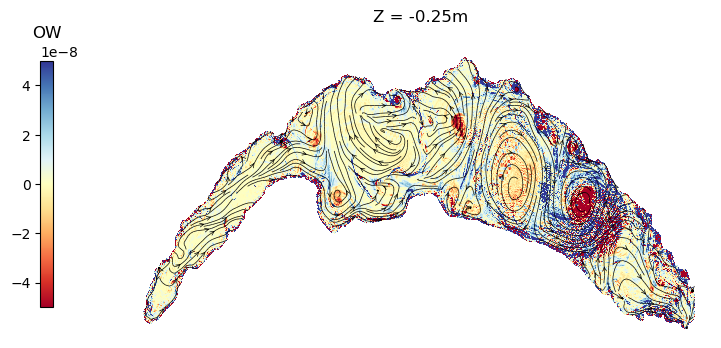

In [152]:
fig, ax = plt.subplots(figsize=(10,4))

T_plot = data['time'][-1]
Z_plot = data['Z'][0]
x_plot, y_plot = np.meshgrid(data['XC'], data['YC'])

u_plot = data['UVEL'].sel(time=T_plot, Z=Z_plot).values
v_plot = data['VVEL'].sel(time=T_plot, Z=Z_plot).values


# Plot vorticity with the custom colormap
OW_plot = data_OW['OW'].sel(time=T_plot).where(~np.isnan(mask))
plot_obj = OW_plot.plot(ax=ax, vmin= -5e-8, vmax=5e-8, cmap='RdYlBu', add_colorbar=False)

cbar = fig.colorbar(plot_obj, ax=ax, orientation='vertical', location='left', shrink=0.8, pad=0.1)
cbar.ax.set_title("OW", fontsize=12)  # Label on top

# Streamplot for velocity field
plt.streamplot(x_plot, y_plot, u_plot, v_plot, density=4, color='black', linewidth=0.5, arrowsize=0.7, arrowstyle='->')

plt.title(f"Z = {Z_plot.values}m")


ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('OW_streamline.png')
#print('saved '+ outputpath + 'OW.png')

### Threshold for the Okubo-Weiss parameter
Some sort of threshold needs to be defined for the Okubo-Weiss parameter to distinguish regions within and outside of eddies. This is usually defined as `OW_thr = a * sigma` ([Chelton et al., 2007](https://doi.org/10.1029/2007GL030812)), where `sigma` is the spatial standard deviation of the Okubo-Weiss parameter and `a` is some factor (more on the factor later).  
In regions with highly variable dynamic conditions, detection based on a single values of this standard deviation often fails to detect eddies in more "quiet" areas of the ocean ([Isern-Fontanet et al., 2003](https://doi.org/10.1175/1520-0426(2003)20<772:IOMEFA>2.0.CO;2)). Thus we here define a spatially variable threshold for the Okubo-Weiss parameter by calculating the (2D) spatial standard deviation in moving boxes.

We define some functions used for computation of this 2D rolling standard deviation. First, we create a convolution function that "ignores" NaNs, i.e. land values.

In [20]:
def nanconv(a, k, MODE):
    # Flat function for comparison.
    o = np.ones(np.shape(a))
    # Flat function with NaNs for comparison.
    on = np.ones(np.shape(a))
    # Find all the NaNs in the input and replace with 0
    an = np.where(~np.isnan(a), a, 0)
    on = np.where(~np.isnan(a), on, 0)
    # Calculate what a 'flat' function looks like after convolution.
    flat = convolve(on, k, mode=MODE)
    #
    # The line above will automatically include a correction for edge 
    # effects,
    # so remove that correction if the user does not want it.
    flat = flat / convolve(o, k, mode=MODE)
    #
    # Do the actual convolution
    output = convolve(an, k, mode=MODE) / flat
    return np.where(~np.isnan(a), output, np.nan)

Then we need to compute the rolling standard deviation. To do this efficiently, we compute it using only averages (which are easy to compute with convolutions). In each of the rolling window, we compute

$ STD_{OW} =  \left( \overline{(OW - \overline{OW})^{2}} \right) ^{0.5} $

In [21]:
def spatial_std(data, wx, wy):
    window = np.ones((1, wy, wx)) / (wy * wx)
    ext = np.zeros((np.shape(data)[0], 
                    np.shape(data)[1] + wy, np.shape(data)[2] + wx))
    print('stage 1')
    ext[:, int(wy/2):-int(wy/2), int(wx/2):-int(wx/2)] = data
    print('stage 2')
    ext[:, 0:int(wy/2), :] = ext[:, int(wy):int(wy/2):-1, :]
    print('stage 3')
    ext[:, -int(wy/2)::, :] = ext[:, -int(wy/2):-int(wy):-1, :]
    print('stage 4')
    ext[:, :, 0:int(wx/2)] = ext[:, :, int(wx):int(wx/2):-1]
    print('stage 5')
    ext[:, :, -int(wx/2)::] = ext[:, :, -int(wx/2):-int(wx):-1]
    print('stage 6')
    std_tmp1 = np.abs(ext - nanconv(ext, window, "same")) ** 2
    print('stage 7')
    std_tmp2 = nanconv(std_tmp1, window, "same") ** 0.5
    print('stage 8')
    output =  xr.DataArray(std_tmp2[:, int(wy/2):-int(wy/2), int(wx/2):-int(wx/2)], 
                           coords=data.coords, dims=data.dims).mean("time") 
    return output

OW_tmp = data['OW'].compute()
print('stage 0')
#OW_tmp2 = OW_tmp.where(OW_tmp != 0)

wx = 0 # rolling window size in x-direction
wy = 0 # rolling window size in y-direction

mean_OW_spatial_std = spatial_std(OW_tmp, wx, wy)

In [22]:
mean_OW_spatial_std = data['OW'].values.mean()


It is also possible to use the mean spatial standard deviation of the Okubo-Weiss parameter over the whole considered region. To do that execute the cell below instead of the one above! Please note that `'OW_thr'` in `detection_parameters` needs to be defined differently, depending on which method of calculating the standard deviation you choose.

mean_OW_spatial_std = data['OW'].std(('YG', 'XG'), skipna=True).mean('time') # uncomment if necessary

In [23]:
# use if OW_std is 2D
#data_int = data.update({'OW_std': (['lat', 'lon'], mean_OW_spatial_std.values)})

In [25]:
# use if OW_std is 1D
data_int = data.update({'OW_std': mean_OW_spatial_std})

In [26]:
# Store the interpolated field on disk so we do not have to do the interpolation again
data_int[['vort','OW','OW_std']].to_netcdf(outputpath + output_name, mode='w')

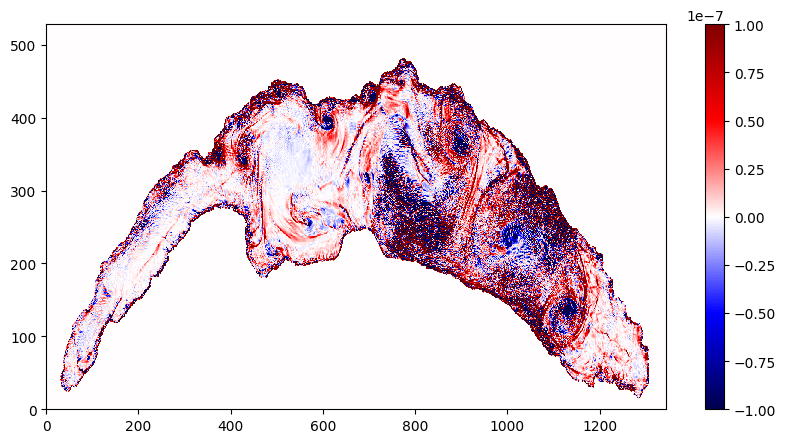

In [27]:
# Let's have a look at the fields
plt.figure(figsize=(10,5))
plt.pcolormesh(data_int['OW'].isel(time=-1), vmin= -1e-7, vmax=1e-7, cmap='seismic')
plt.colorbar()